# 자동차 매출 데이터를 이용한 리포트 작성

## 재구매율

* 재구매율: 특정 기간1 구매자 중 특정 기간2에 연달아 구매한 구매자의 비중을 말함

In [ ]:
# 재구매율 예시 코드
SELECT A.customerNumber, A.orderDate, B.customerNumber, B.orderDate
FROM orders A
LEFT JOIN orders B
ON A.customerNumber = B.customerNumber AND SUBSTR(A.orderDate, 1, 4) = SUBSTR(B.orderDate, 1, 4) -1;

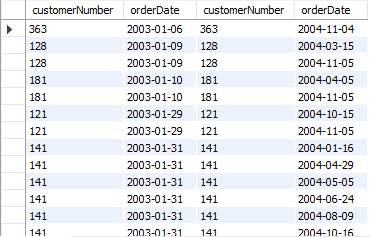

* 위 쿼리를 보면 Order(A)의 SUBSTR(A.orderDate, 1, 4)와 B의 SUBSTR(B.orderDate, 1, 4) - 1을 결합하게 된다.
* 즉, Order(A)의 customer A의 2003년도 거래 건에는 2004년도 거래가 매칭되고, 2004년 거래 건에는 2005년 거래가 없어 어떤 값도 매칭되지 않는다.

### 1. 국가별 2004, 2005 Retention Rate(%)

* 국가별 Retention Rate -> A국가 거주 구매자 중 다음 연도에도 구매를 한 구매자의 비중
* 위에 작성한 쿼리에 고객의 거주 국가 정보를 결합한 후 거주 국가로 그룹핑해 Retention Rate을 구하면 된다.

In [ ]:
# 국가별 2004, 2005 재구매율
SELECT C.country, SUBSTR(A.orderDate, 1, 4) YY,
COUNT(DISTINCT A.customerNumber) BU_1,
COUNT(DISTINCT B.customerNumber) BU_2,
COUNT(DISTINCT B.customerNumber) / COUNT(DISTINCT A.customerNumber) Retention_Rate
FROM orders A
LEFT JOIN orders B
ON A.customerNumber = B.customerNumber AND SUBSTR(A.orderDate, 1, 4) = SUBSTR(B.orderDate, 1, 4) -1
LEFT JOIN customers C
ON A.customerNumber = C.customerNumber
GROUP BY 1, 2;

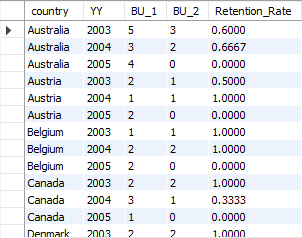

## Best Seller

In [ ]:
# 미국의 연도별 Top5 차량 모델 추출
CREATE TABLE product_sales AS
SELECT D.productName, SUM(quantityOrdered * priceEach) Sales
FROM orders A
LEFT JOIN customers B
ON A.customerNumber = B.customerNumber
LEFT JOIN orderdetails c
ON A.orderNumber = C.orderNumber
LEFT JOIN products D
ON C.productCode = D.productCode
WHERE B.country = 'USA'
GROUP BY 1;

SELECT *
FROM
(SELECT *,
ROW_NUMBER() OVER(ORDER BY Sales DESC) RNK
FROM product_sales) A
WHERE RNK <= 5
ORDER BY RNK;

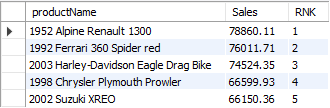

* 미국의 Top5 제품명을 추출하기 위해서 필요한 테이블은 총 4개이다.
* 쿼리가 너무 길어진다면, 테이블로 데이터를 생성한 후, 한 번 더 쿼리를 작성해 추출하는 것이 좋을 수 있다.

## Churn Rate(%)

* 활동 고객 중 얼마나 많은 고객이 비활동 고객으로 전환되었는지 의미하는 지표
* 고객 한명을 획득하는 비용을 Acquisition Cost
* **Churn**: max(구매일, 접속일) 이후 일정 기간(ex.3개월), 구매, 접속하지 않은 상태
* 즉, 마지막 구매, 접속일이 현재 시점 기준으로 3개월 이상 지난 고객을 의미
* 전체 고객 중에 Churn에 해당하는 고객의 비중을 Churn Rate(%)

### 1. Churn Rate(%) 구하기

In [ ]:
# order 테이블에서 마지막 구매일 확인
SELECT MAX(orderDate) MX_Order
FROM orders;

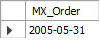

In [ ]:
# 각 고객의 마지막 구매일 구하기
SELECT customerNumber, MAX(orderDate) MX_Order
FROM orders
GROUP BY 1;

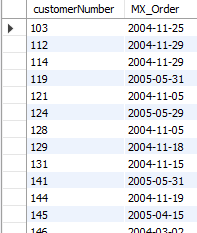

#### DATEDIFF()
* DATEDIFF(date1, date2)
* date1 - date2의 결과가 출력된다.

In [ ]:
# 2005-06-01 기준으로 며칠이 소요되었는지 계산, DATEDIFF() 이용
SELECT customerNumber, MX_Order, '2005-06-01', DATEDIFF('2005-06-01', MX_Order) DIFF
FROM
(SELECT customerNumber, MAX(orderDate) MX_Order
FROM orders
GROUP BY 1) BASE;

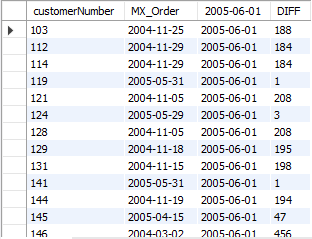

* DIFF는 MX_Order와 END_POINT의 차이를 나타낸다.
* DIFF가 90일 이상인 경우를 Churn이라 가정하고 다음의 쿼리를 수행한다.

In [ ]:
# DIFF가 90일 이상인 경우를 Churn이라 가정
SELECT *,
CASE WHEN DIFF >= 90 THEN 'CHURN' ELSE 'NON-CHURN' END CHURN_TYPE
FROM
(SELECT customerNumber, MX_Order, '2005-06-01' END_POINT,
DATEDIFF('2005-06-01', MX_Order) DIFF
FROM
(SELECT customerNumber, MAX(orderDate) MX_Order
FROM orders
GROUP BY 1) BASE) BASE;

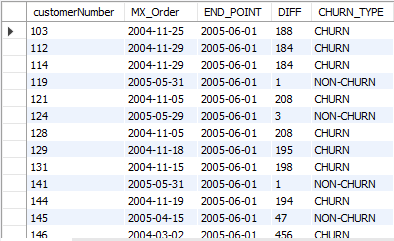

In [ ]:
# churn rate(%)
SELECT CASE WHEN DIFF >= 90 THEN 'CHURN' ELSE 'NON-CHURN' END CHURN_TYPE,
COUNT(DISTINCT customerNumber) N_CUS
FROM
(SELECT customerNumber, MX_Order, '2005-06-01' END_POINT,
DATEDIFF('2005-06-01', MX_Order) DIFF
FROM
(SELECT customerNumber, MAX(orderDate) MX_Order
FROM orders
GROUP BY 1) BASE) BASE
GROUP BY 1;

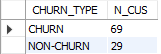

* Churn Rate은  69/(69+29) = 0.70408...으로, 약 70%로 나타난다.

### 2. Churn 고객이 가장 많이 구매한 Productline

* Churn고객의 특성을 파악하고자 어떤 카테고리 상품을 많이 구매했는지 파악해보기 위해 Churn_list 테이블을 생성한다.

In [ ]:
# Churn고객이 어떤 카테고리 상품을 많이 구매했는지 파악하기 위해 Churn_list 테이블 생성
CREATE TABLE Churn_list AS
SELECT CASE WHEN DIFF >= 90 THEN 'CHURN' ELSE 'NON-CHURN' END CHURN_TYPE,
customerNumber
FROM
(SELECT customerNumber, MX_Order, '2005-06-01' END_Point,
DATEDIFF('2005-06-01', MX_Order) DIFF
FROM
(SELECT customerNumber, MAX(orderDate) MX_Order
FROM orders
GROUP BY 1) BASE) BASE;

* orderdetails, orders, products를 결합해 productline별 구매자 수를 구한다.
  

In [ ]:
# productline별 구매자 수
SELECT C.productLine, COUNT(DISTINCT B.customerNumber) BU
FROM orderdetails A
LEFT JOIN orders B
ON A.orderNumber = B.orderNumber
LEFT JOIN products C
ON A.productCode = C.productCode
GROUP BY 1;

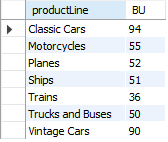

* 위의 결과에 앞에서 생성한 Churn_list를 결합해 Churn Type으로 데이터를 한 번 더 나워 주어야 한다.

In [ ]:
# 위의 결과에 앞에서 생성한 Churn_list를 결합해 Churn Type으로 데이터를 분할
SELECT D.CHURN_TYPE, C.productline, COUNT(DISTINCT B.customerNumber) BU
FROM orderdetails A
LEFT JOIN orders B
ON A.orderNumber = B.orderNumber
LEFT JOIN products C
ON A.productCode = C.productCode
LEFT JOIN churn_list D
ON B.customerNumber = D.customerNumber
GROUP BY 1, 2
ORDER BY 1, 3 DESC;

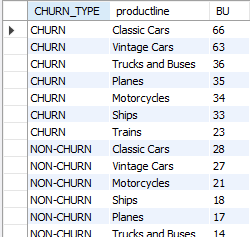